Starting Sentiment Analysis for YOLOv7 Pipeline
Dataset already exists, skipping download...
Loading and preprocessing data...


Loading reviews: 10000it [00:00, 79598.58it/s]

Loaded 10000 reviews
Columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']


After preprocessing: 9206 reviews
Performing sentiment analysis...
Loading sentiment model: cardiffnlp/twitter-roberta-base-sentiment-latest


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Analyzing sentiment: 100%|███████████████████████████████████████████████████████████| 288/288 [30:16<00:00,  6.31s/it]


Creating YOLOv7 annotations...


Creating annotations: 100%|████████████| 9206/9206 [02:01<00:00, 75.65it/s]


Creating synthetic images...


Generating images: 100%|███████████████| 9206/9206 [05:03<00:00, 30.34it/s]


Generating analytics report...


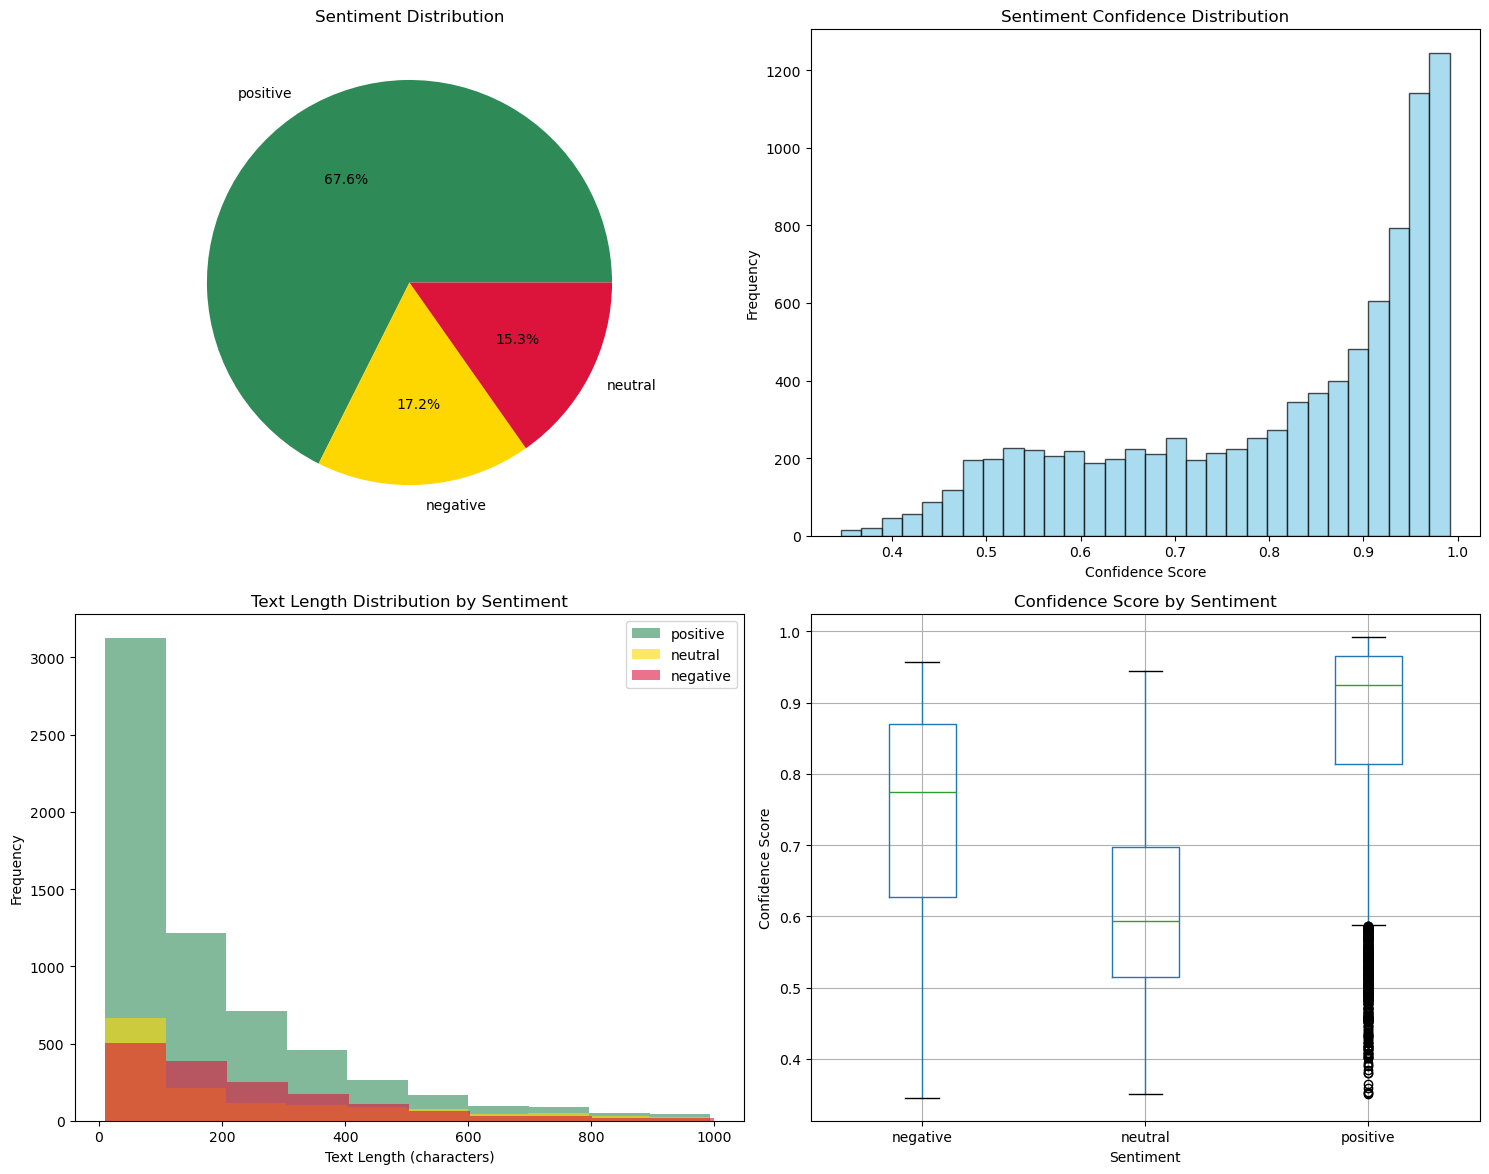


=== SENTIMENT ANALYSIS SUMMARY ===
Total Reviews Processed: 9,206
Average Confidence Score: 0.806

Sentiment Distribution:
  Positive: 6,223 (67.6%)
  Negative: 1,579 (17.2%)
  Neutral: 1,404 (15.3%)
Saving results...

All results saved to: yolo_sentiment_output/
Dataset ready for YOLOv7 training!

PIPELINE COMPLETED SUCCESSFULLY!
Total Execution Time: 0:37:27.363183
Processed 9,206 reviews
Created 9,206 annotations
Output Directory: yolo_sentiment_output/

Additional files created:
   - yolo_sentiment_output/train_yolov7.py (YOLOv7 training script)

To use this dataset with YOLOv7:
   1. Clone YOLOv7 repository
   2. Copy the dataset.yaml to YOLOv7 directory
   3. Update paths in dataset.yaml
   4. Run: python train.py --data dataset.yaml


In [7]:
import os
import json
import gzip
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import pipeline
from tqdm import tqdm
import gc
from PIL import Image, ImageDraw, ImageFont
import warnings
warnings.filterwarnings('ignore')
import torch

# Configuration
CONFIG = {
    'dataset_url': 'https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/Automotive.jsonl.gz',
    'dataset_path': 'Automotive.jsonl.gz',
    'output_dir': 'yolo_sentiment_output',
    'batch_size': 32,
    'max_samples': 10000,  # Limit for optimization
    'image_size': (640, 640),  # YOLOv7 standard input size
    'sentiment_model': 'cardiffnlp/twitter-roberta-base-sentiment-latest',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Create output directories
os.makedirs(CONFIG['output_dir'], exist_ok=True)
os.makedirs(f"{CONFIG['output_dir']}/images", exist_ok=True)
os.makedirs(f"{CONFIG['output_dir']}/labels", exist_ok=True)
os.makedirs(f"{CONFIG['output_dir']}/annotations", exist_ok=True)

class OptimizedSentimentAnalyzer:
    """Optimized sentiment analyzer with batch processing"""
    
    def __init__(self, model_name, device='cpu', batch_size=32):
        self.device = device
        self.batch_size = batch_size
        
        # Load model and tokenizer
        print(f"Loading sentiment model: {model_name}")
        self.sentiment_pipeline = pipeline(
            "sentiment-analysis",
            model=model_name,
            tokenizer=model_name,
            device=0 if device == 'cuda' else -1,
            return_all_scores=True,
            batch_size=batch_size
        )
        
        # Define sentiment mapping for the Twitter RoBERTa model
        self.sentiment_mapping = {
            'LABEL_0': 'negative',  # Negative
            'LABEL_1': 'neutral',   # Neutral
            'LABEL_2': 'positive'   # Positive
        }
        
    def analyze_batch(self, texts):
        """Analyze sentiment for a batch of texts"""
        try:
            # Clean and prepare texts
            cleaned_texts = [str(text)[:512] if text else "" for text in texts]
            
            # Get predictions
            results = self.sentiment_pipeline(cleaned_texts)
            
            # Process results
            processed_results = []
            for result in results:
                # Get the highest scoring sentiment
                best_sentiment = max(result, key=lambda x: x['score'])
                sentiment_label = self.sentiment_mapping.get(
                    best_sentiment['label'], 
                    best_sentiment['label'].lower()
                )
                
                processed_results.append({
                    'sentiment': sentiment_label,
                    'confidence': best_sentiment['score'],
                    'all_scores': {self.sentiment_mapping.get(r['label'], r['label']): r['score'] for r in result}
                })
                
            return processed_results
            
        except Exception as e:
            print(f"Error in batch analysis: {e}")
            return [{'sentiment': 'neutral', 'confidence': 0.0, 'all_scores': {}} for _ in texts]

def download_dataset():
    """Download the Amazon automotive reviews dataset"""
    if os.path.exists(CONFIG['dataset_path']):
        print("Dataset already exists, skipping download...")
        return
    
    print("Downloading Amazon Automotive Reviews dataset...")
    try:
        response = requests.get(CONFIG['dataset_url'], stream=True)
        response.raise_for_status()
        
        total_size = int(response.headers.get('content-length', 0))
        with open(CONFIG['dataset_path'], 'wb') as file, tqdm(
            desc="Downloading",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as pbar:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
                pbar.update(len(chunk))
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        raise

def load_and_preprocess_data():
    """Load and preprocess the JSONL dataset"""
    print("Loading and preprocessing data...")
    
    reviews = []
    try:
        with gzip.open(CONFIG['dataset_path'], 'rt', encoding='utf-8') as file:
            for i, line in enumerate(tqdm(file, desc="Loading reviews")):
                if i >= CONFIG['max_samples']:
                    break
                try:
                    review = json.loads(line.strip())
                    reviews.append(review)
                except json.JSONDecodeError:
                    continue
    except Exception as e:
        print(f"Error loading dataset: {e}")
        raise
    
    df = pd.DataFrame(reviews)
    print(f"Loaded {len(df)} reviews")
    print(f"Columns: {df.columns.tolist()}")
    
    # Handle different possible column names for text and rating
    text_columns = ['reviewText', 'text', 'review_text', 'summary']
    rating_columns = ['overall', 'rating', 'score']
    
    # Find text column
    text_col = None
    for col in text_columns:
        if col in df.columns:
            text_col = col
            break
    
    if text_col is None:
        # Use the first string column as text
        string_cols = df.select_dtypes(include=['object']).columns
        if len(string_cols) > 0:
            text_col = string_cols[0]
        else:
            raise ValueError("No suitable text column found in dataset")
    
    df['text'] = df[text_col].astype(str)
    
    # Find rating column if available
    rating_col = None
    for col in rating_columns:
        if col in df.columns:
            rating_col = col
            break
    
    if rating_col:
        df['rating'] = df[rating_col]
    else:
        df['rating'] = 'N/A'
    
    # Clean data
    df = df.dropna(subset=['text'])
    df['text'] = df['text'].astype(str)
    df['text_length'] = df['text'].str.len()
    
    # Filter out very short or very long reviews
    df = df[(df['text_length'] >= 10) & (df['text_length'] <= 1000)]
    
    print(f"After preprocessing: {len(df)} reviews")
    return df.reset_index(drop=True)

def perform_sentiment_analysis(df):
    """Perform optimized sentiment analysis"""
    print("Performing sentiment analysis...")
    
    # Initialize analyzer
    analyzer = OptimizedSentimentAnalyzer(
        CONFIG['sentiment_model'], 
        CONFIG['device'], 
        CONFIG['batch_size']
    )
    
    # Process in batches
    texts = df['text'].tolist()
    all_results = []
    
    for i in tqdm(range(0, len(texts), CONFIG['batch_size']), desc="Analyzing sentiment"):
        batch_texts = texts[i:i + CONFIG['batch_size']]
        batch_results = analyzer.analyze_batch(batch_texts)
        all_results.extend(batch_results)
        
        # Memory cleanup
        if i % (CONFIG['batch_size'] * 10) == 0:
            gc.collect()
    
    # Add results to dataframe
    df['sentiment'] = [r['sentiment'] for r in all_results]
    df['sentiment_confidence'] = [r['confidence'] for r in all_results]
    df['sentiment_scores'] = [r['all_scores'] for r in all_results]
    
    return df

def create_yolo_annotations(df):
    """Create YOLOv7 compatible annotations from sentiment analysis"""
    print("Creating YOLOv7 annotations...")
    
    # Define class mapping for YOLOv7
    class_mapping = {
        'positive': 0,
        'neutral': 1, 
        'negative': 2
    }
    
    # Create class names file
    with open(f"{CONFIG['output_dir']}/classes.names", 'w', encoding='utf-8') as f:
        for sentiment in ['positive', 'neutral', 'negative']:
            f.write(f"{sentiment}\n")
    
    yolo_annotations = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Creating annotations"):
        # Create synthetic bounding box based on sentiment confidence
        confidence = row['sentiment_confidence']
        sentiment = row['sentiment']
        
        # Generate bounding box coordinates (normalized 0-1)
        # Higher confidence = larger bounding box
        box_size = 0.3 + (confidence * 0.4)  # Box size between 0.3 and 0.7
        
        # Center coordinates with some randomness
        center_x = 0.5 + np.random.uniform(-0.2, 0.2)
        center_y = 0.5 + np.random.uniform(-0.2, 0.2)
        
        # Ensure coordinates are within bounds
        center_x = np.clip(center_x, box_size/2, 1 - box_size/2)
        center_y = np.clip(center_y, box_size/2, 1 - box_size/2)
        
        annotation = {
            'image_id': f"review_{idx:06d}",
            'class_id': class_mapping[sentiment],
            'class_name': sentiment,
            'bbox': [center_x, center_y, box_size, box_size],  # [x_center, y_center, width, height]
            'confidence': confidence,
            'text': row['text'][:100] + "..." if len(row['text']) > 100 else row['text'],
            'original_rating': row.get('rating', 'N/A')
        }
        
        yolo_annotations.append(annotation)
        
        # Create YOLO format label file
        os.makedirs(f"{CONFIG['output_dir']}/labels", exist_ok=True)
        label_file = f"{CONFIG['output_dir']}/labels/review_{idx:06d}.txt"
        with open(label_file, 'w', encoding='utf-8') as f:
            f.write(f"{class_mapping[sentiment]} {center_x:.6f} {center_y:.6f} {box_size:.6f} {box_size:.6f}\n")
    
    return yolo_annotations

def create_synthetic_images(annotations):
    """Create synthetic images for YOLOv7 training"""
    print("Creating synthetic images...")
    
    # Color mapping for sentiments
    color_mapping = {
        'positive': (0, 255, 0),    # Green
        'neutral': (255, 255, 0),   # Yellow  
        'negative': (255, 0, 0)     # Red
    }
    
    for i, ann in enumerate(tqdm(annotations, desc="Generating images")):
        # Create blank image
        img = np.ones((CONFIG['image_size'][1], CONFIG['image_size'][0], 3), dtype=np.uint8) * 240
        
        # Convert to PIL for text rendering
        pil_img = Image.fromarray(img)
        draw = ImageDraw.Draw(pil_img)
        
        # Draw bounding box
        bbox = ann['bbox']
        x_center, y_center, width, height = bbox
        
        # Convert normalized coordinates to pixel coordinates
        img_w, img_h = CONFIG['image_size']
        x1 = int((x_center - width/2) * img_w)
        y1 = int((y_center - height/2) * img_h)
        x2 = int((x_center + width/2) * img_w)
        y2 = int((y_center + height/2) * img_h)
        
        # Draw rectangle
        color = color_mapping[ann['class_name']]
        draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
        
        # Add text with error handling
        try:
            # Try different font options
            font_paths = [
                "arial.ttf", "Arial.ttf", "calibri.ttf", "Calibri.ttf",
                "/System/Library/Fonts/Arial.ttf",  # macOS
                "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"  # Linux
            ]
            font = None
            for font_path in font_paths:
                try:
                    font = ImageFont.truetype(font_path, 20)
                    break
                except:
                    continue
            if font is None:
                font = ImageFont.load_default()
        except:
            font = ImageFont.load_default()
        
        text = f"{ann['class_name']} ({ann['confidence']:.2f})"
        draw.text((x1, max(0, y1-25)), text, fill=color, font=font)
        
        # Add review snippet (clean text for display)
        review_text = ann['text'][:60] + "..." if len(ann['text']) > 60 else ann['text']
        # Remove any problematic characters
        review_text = ''.join(char if ord(char) < 128 else '?' for char in review_text)
        draw.text((10, 10), review_text, fill=(0, 0, 0), font=font)
        
        # Save image
        os.makedirs(f"{CONFIG['output_dir']}/images", exist_ok=True)
        img_path = f"{CONFIG['output_dir']}/images/{ann['image_id']}.jpg"
        pil_img.save(img_path)

def create_yolo_dataset_config():
    """Create YOLOv7 dataset configuration"""
    config = {
        'path': CONFIG['output_dir'],
        'train': 'images',
        'val': 'images',  # Using same for simplicity
        'nc': 3,  # Number of classes
        'names': ['positive', 'neutral', 'negative']
    }
    
    # Use safe_dump to handle encoding properly
    try:
        import yaml
        with open(f"{CONFIG['output_dir']}/dataset.yaml", 'w', encoding='utf-8') as f:
            yaml.safe_dump(config, f, default_flow_style=False)
    except ImportError:
        # Fallback if PyYAML is not available
        with open(f"{CONFIG['output_dir']}/dataset.yaml", 'w', encoding='utf-8') as f:
            f.write(f"path: {config['path']}\n")
            f.write(f"train: {config['train']}\n")
            f.write(f"val: {config['val']}\n")
            f.write(f"nc: {config['nc']}\n")
            f.write("names:\n")
            for name in config['names']:
                f.write(f"  - {name}\n")

def generate_analytics_report(df, annotations):
    """Generate comprehensive analytics report"""
    print("Generating analytics report...")
    
    # Set up plotting
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Sentiment Analysis Report for YOLOv7 Dataset', fontsize=16, fontweight='bold')
    
    # Sentiment distribution
    sentiment_counts = df['sentiment'].value_counts()
    axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
                   colors=['#2E8B57', '#FFD700', '#DC143C'])
    axes[0, 0].set_title('Sentiment Distribution')
    
    # Confidence distribution
    axes[0, 1].hist(df['sentiment_confidence'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 1].set_title('Sentiment Confidence Distribution')
    axes[0, 1].set_xlabel('Confidence Score')
    axes[0, 1].set_ylabel('Frequency')
    
    # Text length vs sentiment
    sentiment_colors = {'positive': '#2E8B57', 'neutral': '#FFD700', 'negative': '#DC143C'}
    for sentiment in df['sentiment'].unique():
        data = df[df['sentiment'] == sentiment]['text_length']
        axes[1, 0].hist(data, alpha=0.6, label=sentiment, color=sentiment_colors.get(sentiment, 'gray'))
    axes[1, 0].set_title('Text Length Distribution by Sentiment')
    axes[1, 0].set_xlabel('Text Length (characters)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    
    # Confidence by sentiment
    df.boxplot(column='sentiment_confidence', by='sentiment', ax=axes[1, 1])
    axes[1, 1].set_title('Confidence Score by Sentiment')
    axes[1, 1].set_xlabel('Sentiment')
    axes[1, 1].set_ylabel('Confidence Score')
    plt.suptitle('')  # Remove automatic title from boxplot
    
    plt.tight_layout()
    plt.savefig(f"{CONFIG['output_dir']}/sentiment_analysis_report.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Generate summary statistics
    summary_stats = {
        'total_reviews': len(df),
        'sentiment_distribution': df['sentiment'].value_counts().to_dict(),
        'average_confidence': float(df['sentiment_confidence'].mean()),
        'confidence_by_sentiment': {
            k: {'mean': float(v['mean']), 'std': float(v['std'])} 
            for k, v in df.groupby('sentiment')['sentiment_confidence'].agg(['mean', 'std']).to_dict('index').items()
        },
        'text_length_stats': {
            'mean': float(df['text_length'].mean()),
            'median': float(df['text_length'].median()),
            'std': float(df['text_length'].std())
        }
    }
    
    # Save summary with proper encoding
    with open(f"{CONFIG['output_dir']}/summary_stats.json", 'w', encoding='utf-8') as f:
        json.dump(summary_stats, f, indent=2, ensure_ascii=False)
    
    print("\n=== SENTIMENT ANALYSIS SUMMARY ===")
    print(f"Total Reviews Processed: {summary_stats['total_reviews']:,}")
    print(f"Average Confidence Score: {summary_stats['average_confidence']:.3f}")
    print("\nSentiment Distribution:")
    for sentiment, count in summary_stats['sentiment_distribution'].items():
        percentage = (count / summary_stats['total_reviews']) * 100
        print(f"  {sentiment.capitalize()}: {count:,} ({percentage:.1f}%)")
    
    return summary_stats

def save_results(df, annotations, summary_stats):
    """Save all results and create final dataset"""
    print("Saving results...")
    
    # Save processed dataframe with proper encoding
    df.to_csv(f"{CONFIG['output_dir']}/processed_reviews.csv", index=False, encoding='utf-8')
    df.to_pickle(f"{CONFIG['output_dir']}/processed_reviews.pkl")
    
    # Save annotations with proper encoding
    with open(f"{CONFIG['output_dir']}/annotations/yolo_annotations.json", 'w', encoding='utf-8') as f:
        json.dump(annotations, f, indent=2, ensure_ascii=False)
    
    # Create train/val split for YOLOv7
    train_annotations, val_annotations = train_test_split(
        annotations, test_size=0.2, random_state=42, stratify=[ann['class_name'] for ann in annotations]
    )
    
    # Save split information
    split_info = {
        'train_size': len(train_annotations),
        'val_size': len(val_annotations),
        'train_ids': [ann['image_id'] for ann in train_annotations],
        'val_ids': [ann['image_id'] for ann in val_annotations]
    }
    
    with open(f"{CONFIG['output_dir']}/train_val_split.json", 'w', encoding='utf-8') as f:
        json.dump(split_info, f, indent=2, ensure_ascii=False)
    
    # Create README with ASCII-safe content
    readme_content = f"""# Sentiment Analysis Dataset for YOLOv7

Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Dataset Overview
- **Source**: Amazon Automotive Reviews
- **Total Samples**: {len(df):,}
- **Classes**: 3 (positive, neutral, negative)
- **Image Size**: {CONFIG['image_size'][0]}x{CONFIG['image_size'][1]}

## Sentiment Distribution
{chr(10).join([f"- {k.capitalize()}: {v:,} samples" for k, v in summary_stats['sentiment_distribution'].items()])}

## Files Structure
```
{CONFIG['output_dir']}/
├── images/                     # Synthetic images
├── labels/                     # YOLOv7 format labels
├── annotations/               # JSON annotations
├── dataset.yaml              # YOLOv7 dataset config
├── classes.names             # Class names
├── processed_reviews.csv     # Processed review data
├── summary_stats.json        # Summary statistics
└── sentiment_analysis_report.png
```

## Usage with YOLOv7
1. Update the `path` in `dataset.yaml` to your local directory
2. Use this dataset for training: `python train.py --data dataset.yaml`

## Performance Metrics
- Average Confidence: {summary_stats['average_confidence']:.3f}
- Model Used: {CONFIG['sentiment_model']}
- Processing Device: {CONFIG['device']}
"""
    
    # Write README with UTF-8 encoding
    with open(f"{CONFIG['output_dir']}/README.md", 'w', encoding='utf-8') as f:
        f.write(readme_content)
    
    print(f"\nAll results saved to: {CONFIG['output_dir']}/")
    print("Dataset ready for YOLOv7 training!")

# Main execution pipeline
def main():
    """Main execution pipeline"""
    start_time = datetime.now()
    print("Starting Sentiment Analysis for YOLOv7 Pipeline")
    print("=" * 60)
    
    try:
        # Step 1: Download dataset
        download_dataset()
        
        # Step 2: Load and preprocess data
        df = load_and_preprocess_data()
        
        # Step 3: Perform sentiment analysis
        df = perform_sentiment_analysis(df)
        
        # Step 4: Create YOLO annotations
        annotations = create_yolo_annotations(df)
        
        # Step 5: Create synthetic images
        create_synthetic_images(annotations)
        
        # Step 6: Create YOLOv7 dataset configuration
        create_yolo_dataset_config()
        
        # Step 7: Generate analytics report
        summary_stats = generate_analytics_report(df, annotations)
        
        # Step 8: Save all results
        save_results(df, annotations, summary_stats)
        
        # Execution summary
        end_time = datetime.now()
        execution_time = end_time - start_time
        
        print("\n" + "=" * 60)
        print("PIPELINE COMPLETED SUCCESSFULLY!")
        print(f"Total Execution Time: {execution_time}")
        print(f"Processed {len(df):,} reviews")
        print(f"Created {len(annotations):,} annotations")
        print(f"Output Directory: {CONFIG['output_dir']}/")
        print("=" * 60)
        
    except Exception as e:
        print(f"Pipeline failed with error: {e}")
        import traceback
        traceback.print_exc()
        raise

if __name__ == "__main__":
    main()

# Additional utility functions for post-processing

def load_saved_results():
    """Load previously saved results"""
    df = pd.read_pickle(f"{CONFIG['output_dir']}/processed_reviews.pkl")
    with open(f"{CONFIG['output_dir']}/annotations/yolo_annotations.json", 'r', encoding='utf-8') as f:
        annotations = json.load(f)
    with open(f"{CONFIG['output_dir']}/summary_stats.json", 'r', encoding='utf-8') as f:
        summary_stats = json.load(f)
    return df, annotations, summary_stats

def create_custom_yolo_training_script():
    """Create a custom YOLOv7 training script"""
    training_script = '''# YOLOv7 Training Script for Sentiment Analysis Dataset

import torch
import os

# Training configuration
config = {
    'weights': 'yolov7.pt',  # Pre-trained weights
    'cfg': 'cfg/training/yolov7.yaml',
    'data': 'dataset.yaml',  # Our dataset config
    'epochs': 100,
    'batch_size': 16,
    'img_size': [640, 640],
    'device': '0',  # GPU device
    'workers': 8,
    'project': 'runs/train',
    'name': 'sentiment_detection'
}

# Command to run training
training_command = f"""
python train.py \\
    --weights {config['weights']} \\
    --cfg {config['cfg']} \\
    --data {config['data']} \\
    --epochs {config['epochs']} \\
    --batch-size {config['batch_size']} \\
    --img-size {config['img_size'][0]} {config['img_size'][1]} \\
    --device {config['device']} \\
    --workers {config['workers']} \\
    --project {config['project']} \\
    --name {config['name']}
"""

print("YOLOv7 Training Command:")
print(training_command)
'''
    
    with open(f"{CONFIG['output_dir']}/train_yolov7.py", 'w', encoding='utf-8') as f:
        f.write(training_script)

# Run the additional utilities if this script is executed directly
if __name__ == "__main__":
    # Create the training script after main execution
    try:
        create_custom_yolo_training_script()
        print("\nAdditional files created:")
        print(f"   - {CONFIG['output_dir']}/train_yolov7.py (YOLOv7 training script)")
        print("\nTo use this dataset with YOLOv7:")
        print("   1. Clone YOLOv7 repository")
        print("   2. Copy the dataset.yaml to YOLOv7 directory") 
        print("   3. Update paths in dataset.yaml")
        print("   4. Run: python train.py --data dataset.yaml")
    except Exception as e:
        print(f"Warning: Could not create training script: {e}")